In [44]:
# %%
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import pennylane as qml
from functools import partial
import matplotlib.pyplot as plt
from utils.helper import *
from utils.models import *

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

In [45]:
n_qubits = 3

In [46]:
## Set your input state
key, inkey, outkey = jr.split(key, 3)
initial_state = jr.normal(inkey, shape=(2**n_qubits)).astype(complex)
target_state = jr.normal(outkey, shape=(2**n_qubits)).astype(complex)
## Normalize for safety
initial_state /= jnp.linalg.norm(initial_state)
target_state /= jnp.linalg.norm(target_state)

# 
n_epochs = 500
n_steps = 40
T = 1.0
lr = 0.05

## Chooce Your Hamiltonian Ansatz
H_list = build_hamiltonians(n_qubits)

In [47]:
## 
key, mlpkey = jax.random.split(key)

model = eqx.nn.MLP(
   in_size='scalar', out_size=len(H_list)-1, depth=2, width_size=16, activation=jax.nn.tanh, key=mlpkey
)
## GRAPE Algorithm
#model = PiecewiseConstantControl(
#    amplitudes=jnp.zeros((n_steps, len(H_list))), 
#    t_final= T, 
#    n_segments=n_steps
#)
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [48]:
# Build circuit for training
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def splitting_circuit(model, initial_state, T, 
                      n_steps, 
                      H_list = H_list,
                      n_qubits=n_qubits, 
                      n=1
    ):
    """ 
    model: control NN
    initial_state: Initial Quantum State
    T: final time
    n_steps: time steps
    H_list : Hamiltanians
    n: trotterizaiton order
    """
    dt = T / n_steps
    H0 = H_list[0]
    qml.StatePrep(initial_state, wires=range(n_qubits))
    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        # Strang-splitting time step
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
    return qml.state()

In [ ]:
@eqx.filter_jit
def loss_fn(model, inital_state, target_state, T=1.0, n_steps=40, C=1e-5):#3e-4):
    psi = splitting_circuit(model, inital_state, T, n_steps)
    fidelity = quantum_fidelity(psi, target_state)
    ## 
    ts = jnp.linspace(0, T, n_steps)
    integral = jax.scipy.integrate.trapezoid(jax.vmap(lambda t : jnp.linalg.norm(model(t))**2)(ts), ts)
    #return jnp.linalg.norm(psi-target_state)**2 + C*integral
    return 1 - fidelity + C*integral

@eqx.filter_jit
def make_step(model, opt_state, initial_state, target_state, optimizer, T=1.0, n_steps=40):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, initial_state, target_state, T, n_steps)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Training
print(f"=== Start training ===")
for step in range(n_epochs):
    model, opt_state, loss = make_step(
        model, opt_state, initial_state, 
        target_state, optimizer, T, n_steps
    )
    if step % (n_epochs // 10) == 0:
        print(f"Step {step:03d}: loss = {loss:.6f}")

rho_f = splitting_circuit(model, initial_state, T, n_steps)
print(f"Final fidelity: {quantum_fidelity(rho_f, target_state)}")


=== Start training ===
Step 000: loss = 0.979894
Step 050: loss = 0.361523
Step 100: loss = 0.293072
Step 150: loss = 0.031049
Step 200: loss = 0.020408
Step 250: loss = 0.014850
Step 300: loss = 0.013303
Step 350: loss = 0.019914
Step 400: loss = 0.009955
Step 450: loss = 0.009247
Final fidelity: 0.9916210868627857


Final fidelity: 0.991621


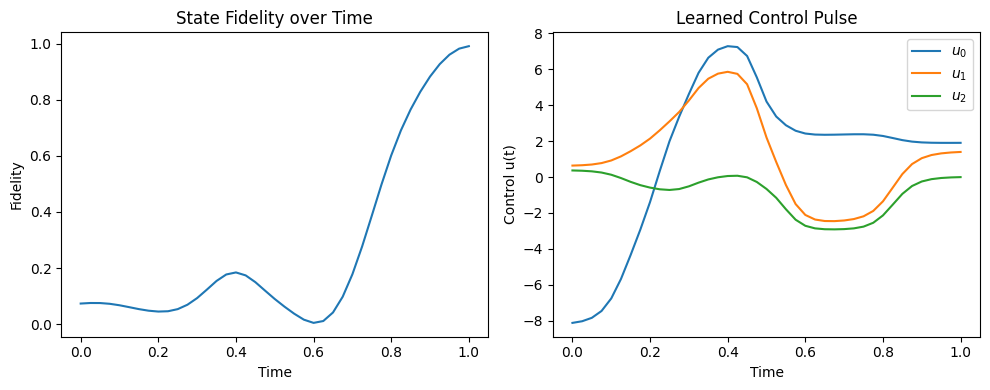

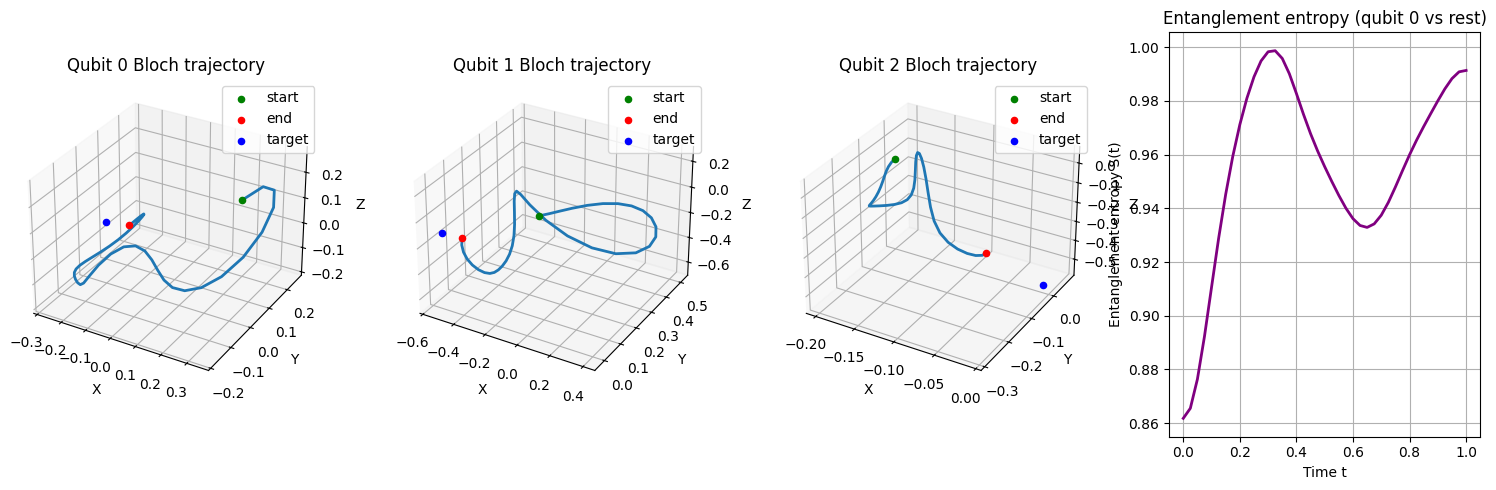

In [ ]:
# %%
def simulate_trajectory(model, initial_state, T, 
                      n_steps, 
                      H_list = H_list,
                      n_qubits=n_qubits, 
                      n=1
    ):
    dt = T / n_steps
    dev = qml.device("default.qubit", wires=n_qubits)

    H0 = H_list[0]

    @qml.qnode(dev)
    def step_evolution(psi_in, u_k):
        qml.StatePrep(psi_in, wires=range(n_qubits))
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
        return qml.state()

    psi = initial_state
    states = [psi]

    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        psi = step_evolution(psi, u_k)
        # normalize for safety
        # psi = psi / jnp.linalg.norm(psi)
        states.append(psi)
    
    return jnp.stack(states)

# %%
trajectory_fidelity = jax.vmap(quantum_fidelity, in_axes=(0, None))
states = simulate_trajectory(model, initial_state, T=T, n_steps=n_steps)

fidelities = trajectory_fidelity(states, target_state)
print(f"Final fidelity: {fidelities[-1]:.6f}")

# %%

times = jnp.linspace(0, T, len(fidelities))
controls = jax.vmap(model)(times)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(times, fidelities)
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("State Fidelity over Time")

plt.subplot(1,2,2)
for i in range(controls.shape[-1]):
    plt.plot(times, controls[:, i], label=f"$u_{i}$")
plt.xlabel("Time")
plt.ylabel("Control u(t)")
plt.title("Learned Control Pulse")
plt.legend()

plt.tight_layout()
plt.show()

visualize_bloch_trajectories(states, target_state, n_qubits)

## Circuit Visualization

We use `pennylane.transforms.decompose` to transpile the circuit

In [51]:
from pennylane.transforms import decompose

dev = qml.device('default.qubit')
allowed_gates = {qml.RX, qml.RY, qml.RZ, qml.CNOT}

@partial(decompose, gate_set=allowed_gates)
#@qml.compile
@qml.qnode(dev)
def circuit(H_list= H_list, n=1):
    H0 = H_list[0]
    dt = 1/n_steps
    qml.StatePrep(initial_state, wires=range(n_qubits))  # |00>
    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        # Strang-splitting time step
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
    
    return qml.state()
print(qml.draw(circuit)())



0: ──RY(1.30)─╭●────────────╭●──────────────╭●─────────────────────────╭●──RZ(-0.79)─╭● ···
1: ──RY(1.52)─╰X──RY(-0.88)─╰X─╭●───────────│────────────╭●────────────│───RZ(-0.79)─╰X ···
2: ──RY(1.60)──────────────────╰X──RY(0.33)─╰X──RY(0.16)─╰X──RY(-0.49)─╰X──RZ(-0.79)─── ···

0: ··· ────────────╭●───────────────╭●──────────────────────────╭●──RZ(1.57)──RX(1.57)──RZ(1.57) ···
1: ··· ──RZ(-0.79)─╰X─╭●────────────│─────────────╭●────────────│───RZ(1.57)──RX(1.57)──RZ(1.57) ···
2: ··· ───────────────╰X──RZ(-0.79)─╰X──RZ(-0.79)─╰X──RZ(-0.79)─╰X──RZ(1.57)──RX(1.57)──RZ(1.57) ···

0: ··· ─╭X──RZ(0.03)─╭X──RZ(1.57)──RX(1.57)──RZ(1.57)──RX(1.57)───────────────────────────────── ···
1: ··· ─╰●───────────╰●──RZ(1.57)──RX(1.57)──RZ(1.57)──RZ(1.57)──RX(1.57)──RZ(1.57)─╭X──RZ(0.03) ···
2: ··· ─────────────────────────────────────────────────────────────────────────────╰●────────── ···

0: ··· ────────────────────────────────────────────╭X──RZ(0.03)─╭X──RX(-1.57)───────────── ···
1: ··· ─╭X──RZ(1.57)